Importing neccessary libraries

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings 
warnings.filterwarnings("ignore")
sns.set(style="white", color_codes=True,rc={'figure.figsize':(20,10)})


Downloading neccesary nltk packages

In [30]:
import nltk
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Loading Dataset and printing some stats

(101634, 5)
Index(['Match_ID', 'Over', 'Commentary', 'Over_Run_Total', 'Target'], dtype='object')
Match_ID          0
Over              0
Commentary        0
Over_Run_Total    0
Target            0
dtype: int64


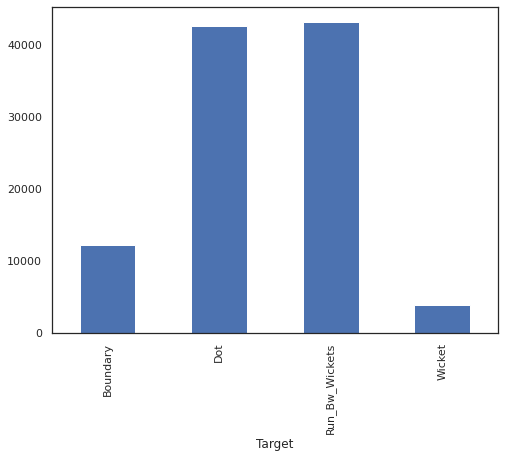

In [31]:
df = pd.read_excel("/content/drive/My Drive/Colab Notebooks/CCC_TrainingData.xlsx",index_col='ID',dtype=str)
# plot(df)
print(df.shape)
print(df.columns)
print(df.isnull().sum())
# value = df['Target'].value_counts()
# print(value)
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('Target').Commentary.count().plot.bar(ylim=0)
plt.show()

Dropping unneccessary features

In [32]:
from io import StringIO
col = ['Commentary', 'Target']
df = df[col]
df = df[pd.notnull(df['Commentary'])]

df['Target_ID'] = df['Target'].factorize()[0]
target_id_df = df[['Target', 'Target_ID']].drop_duplicates().sort_values('Target_ID')
target_to_id = dict(target_id_df.values)
id_to_target = dict(target_id_df[['Target_ID', 'Target']].values)
df.head()

,Commentary,Target,Target_ID
ID,,,
0,and india reach 300. there has been a 300 in ...,Run_Bw_Wickets,0
1,"slower ball, ashwin bunts this to leg for -99...",Run_Bw_Wickets,0
2,"full toss on off, he just slogs, gets a thick...",Run_Bw_Wickets,0
3,that's the closest you'll get to a hat-trick ...,Dot,1
4,sohail is doing the sajda after bowling rahan...,Wicket,2


In [ ]:
from wordcloud import WordCloud
wordcloud = WordCloud().generate(df.Commentary)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Preprocessing Data

In [34]:
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import string
from nltk.corpus import stopwords

PUNCT_TO_REMOVE = string.punctuation
STOPWORDS = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
remove_digits = str.maketrans('', '', '0123456789')
ps = nltk.PorterStemmer()
def clean_data(text):
  text = text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))
  text = text.translate(remove_digits)
  tokens = re.split('\W+', text)
  text = [ps.stem(word) for word in tokens if word not in STOPWORDS]
  return text

df['body_len'] = df['Commentary'].apply(lambda x: len(x) - x.count(" "))

In [ ]:
# bins = np.linspace(0,50,5)
# plt.hist(df[df['Target']=='Run_Bw_Wickets']['body_len'],bins,alpha=0.5,density=True,label='Run_Bw_Wickets')
# plt.hist(df[df['Target']=='Dot']['body_len'],bins,alpha=0.5,density=True,label='Dot')
# plt.hist(df[df['Target']=='Wicket']['body_len'],bins,alpha=0.5,density=True,label='Wicket')
# plt.hist(df[df['Target']=='Boundary']['body_len'],bins,alpha=0.5,density=True,label='Boundary')
# plt.show()

Scaling commentary length feature

In [35]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=False)
scaler.fit(df[['body_len']])
df[['body_len']] = scaler.transform(df[['body_len']])

Vectorizing and creating tf-idf vector matrix

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1,2),max_features=500,analyzer=clean_data)
features = pd.concat([df['body_len'], pd.DataFrame(tfidf.fit_transform(df.Commentary).toarray())],axis=1)
labels = df.Target_ID
features.shape

(101634, 501)

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

display(features.describe())

,body_len,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499
count,101634.000000,101634.000000,101634.000000,101634.000000,101634.000000,101634.000000,101634.000000,101634.000000,101634.000000,101634.000000,101634.000000,101634.000000,101634.000000,101634.000000,101634.000000,101634.000000,101634.000000,101634.000000,101634.000000,101634.000000,101634.000000,101634.000000,101634.000000,101634.000000,101634.000000,101634.000000,101634.000000,101634.000000,101634.000000,101634.000000,101634.000000,101634.000000,101634.000000,101634.000000,101634.000000,101634.000000,101634.000000,101634.000000,101634.000000,101634.000000,...,101634.000000,101634.000000,101634.000000,101634.000000,101634.000000,101634.000000,101634.000000,101634.000000,101634.000000,101634.000000,101634.000000,101634.000000,101634.000000,101634.000000,101634.000000,101634.000000,101634.000000,101634.000000,101634.000000,101634.000000,101634.000000,101634.000000,101634.000000,101634.000000,101634.000000,101634.000000,101634.000000,101634.000000,101634.000000,101634.000000,101634.000000,101634.000000,101634.000000,101634.000000,101634.000000,101634.000000,101634.000000,101634.000000,101634.000000,101634.000000
mean,1.642468,0.095329,0.001861,0.001643,0.012757,0.001636,0.001746,0.001715,0.006194,0.001474,0.002525,0.003542,0.006141,0.002460,0.001864,0.001476,0.011708,0.014233,0.003702,0.003847,0.008803,0.003983,0.042353,0.001594,0.009995,0.001142,0.039191,0.003034,0.013152,0.010064,0.001733,0.006537,0.006785,0.001800,0.008860,0.001889,0.003023,0.004952,0.006564,0.005972,...,0.001148,0.002689,0.001493,0.004177,0.015790,0.006471,0.022943,0.008663,0.011201,0.005782,0.015848,0.002945,0.001415,0.003142,0.001317,0.001319,0.001434,0.004814,0.002900,0.003028,0.001817,0.001477,0.002002,0.002824,0.006191,0.013374,0.003316,0.006320,0.023109,0.001636,0.004177,0.001196,0.002145,0.016362,0.002911,0.002624,0.001718,0.001622,0.008090,0.002884
std,1.000005,0.047790,0.028918,0.028279,0.061486,0.026608,0.028017,0.027247,0.047126,0.025732,0.032914,0.036605,0.057793,0.032661,0.029303,0.026306,0.064797,0.069746,0.036535,0.038756,0.057775,0.040043,0.098735,0.029786,0.059623,0.020083,0.085072,0.036985,0.061412,0.059019,0.027148,0.048982,0.052568,0.027523,0.057603,0.030711,0.037091,0.042318,0.048680,0.056886,...,0.021877,0.035894,0.023448,0.038950,0.074927,0.049678,0.082923,0.058712,0.057840,0.053581,0.076052,0.032385,0.026649,0.035187,0.024094,0.025366,0.024882,0.044811,0.034118,0.033638,0.028977,0.023360,0.031669,0.034901,0.046476,0.063942,0.033955,0.052126,0.084826,0.028575,0.041084,0.023740,0.031478,0.083218,0.031474,0.033785,0.027526,0.027459,0.056658,0.035656
min,0.020165,0.025301,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.967905,0.068043,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,

dividing the dataset into train and test sets and fitting the model

In [38]:
from imblearn.over_sampling import SMOTE
features, labels = SMOTE().fit_resample(features, labels)

Comparing various models on accuracy score through cross validation 

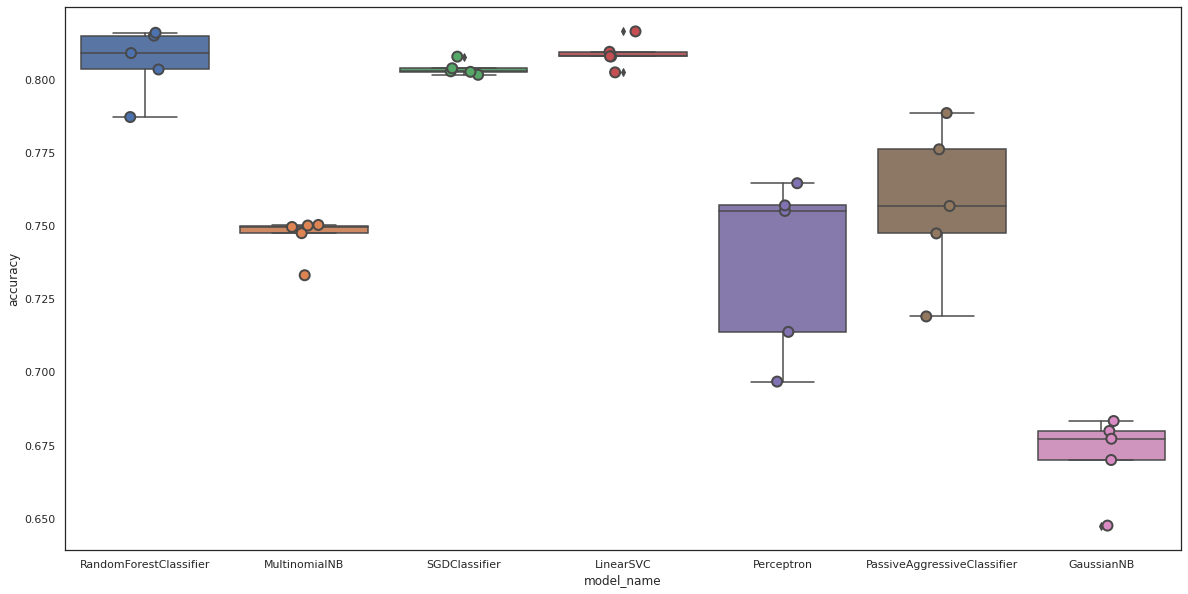

In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
models = [
    RandomForestClassifier(n_estimators=100, max_depth=20, random_state=0,n_jobs=-1),
    MultinomialNB(),
    SGDClassifier(loss="hinge", penalty="l2", max_iter=1000),
    LinearSVC(class_weight= 'balanced'),
    Perceptron(),
    PassiveAggressiveClassifier(),
    GaussianNB()
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=10, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [40]:

cv_df.groupby('model_name').accuracy.mean()


model_name
GaussianNB                     0.671545
LinearSVC                      0.808686
MultinomialNB                  0.746025
PassiveAggressiveClassifier    0.757474
Perceptron                     0.737339
RandomForestClassifier         0.805982
SGDClassifier                  0.803598
Name: accuracy, dtype: float64

In [41]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.30, random_state=0)
model = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=0,n_jobs=-1)
X_train.shape

(120638, 501)

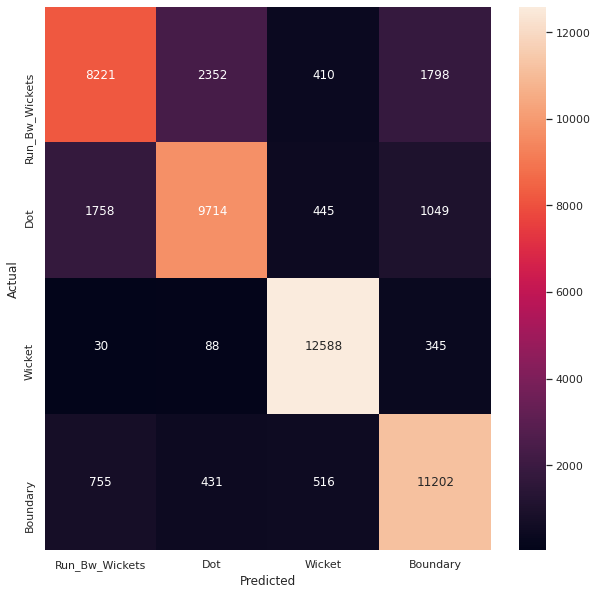

In [50]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=target_id_df.Target.values, yticklabels=target_id_df.Target.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show() #Heatmap to represent confusion matrix

Performance metrices for the model on holdout test set

In [43]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=df['Target'].unique()))
print()
from sklearn.metrics import precision_recall_fscore_support as score
precision, recall, fscore, support = score(y_test, y_pred,average='weighted')
print('Precision: {} / Recall: {} / Accuracy: {} / F1-score: {}'.format(round(precision, 3),
                                                        round(recall, 3),
                                                        round((y_pred==y_test).sum() / len(y_pred),3),round(fscore, 3)))

                precision    recall  f1-score   support

Run_Bw_Wickets       0.76      0.64      0.70     12781
           Dot       0.77      0.75      0.76     12966
        Wicket       0.90      0.96      0.93     13051
      Boundary       0.78      0.87      0.82     12904

      accuracy                           0.81     51702
     macro avg       0.80      0.81      0.80     51702
  weighted avg       0.80      0.81      0.80     51702


Precision: 0.804 / Recall: 0.807 / Accuracy: 0.807 / F1-score: 0.803


Performing classification on unseen data and saving it


In [44]:
test = pd.read_excel("/content/drive/My Drive/Colab Notebooks/CCC_TestData.xlsx",index_col='ID',dtype=str)
test['body_len'] = test['Commentary'].apply(lambda x: len(x) - x.count(" "))
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=False)
scaler.fit(test[['body_len']])
test[['body_len']] = scaler.transform(test[['body_len']])
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1,2),max_features=500,analyzer=clean_data)
features = pd.concat([test['body_len'], pd.DataFrame(tfidf.fit_transform(test.Commentary).toarray())],axis=1)
print(features.shape)
y_pred = model.predict(features)
results = pd.DataFrame (y_pred)
results.columns =['Target'] 
results.head()
results['Target'].replace(id_to_target, inplace=True)
filepath = '/content/drive/My Drive/Colab Notebooks/CCC_SampleOutputPredictionsRF.xlsx'

results.to_excel(filepath, index=False)

(26143, 501)


Saving the model in .sav file

In [45]:
import pickle
filename = '/content/drive/My Drive/Cricket_Classification_RandomForest.sav'
pickle.dump(model, open(filename, 'wb'))